In [16]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import numpy as np
import h5py
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import cv2
import tifffile
import skimage
import pyvips
from skimage import io, transform
from scipy import ndimage as nd
from mpl_toolkits.axes_grid1 import ImageGrid
import json

In [31]:
from albumentations import (
    Compose,
    OneOf,
    Flip,
    Rotate,
    RandomRotate90,
    CLAHE,
    RandomBrightnessContrast,
    RandomGamma,
    GaussianBlur,
    GaussNoise,
    RandomCrop,
    ShiftScaleRotate,
    VerticalFlip,
    HorizontalFlip,
    Normalize,
    RandomCrop,
    RandomScale,
    OpticalDistortion,
    ElasticTransform,
)

In [8]:


BASE_PATH = "./"
TRAIN_PATH = os.path.join(BASE_PATH, "train")
DATA_PATH = os.path.join(BASE_PATH,"processed")


In [9]:
df_train = pd.read_csv(
    os.path.join(BASE_PATH, "train.csv")
)
df_train

,id,encoding
0,2f6ecfcdf,296084587 4 296115835 6 296115859 14 296147109...
1,aaa6a05cc,30989109 59 31007591 64 31026074 68 31044556 7...
2,cb2d976f4,78144363 5 78179297 15 78214231 25 78249165 35...
3,0486052bb,101676003 6 101701785 8 101727568 9 101753351 ...
4,e79de561c,7464094 14 7480273 41 7496453 67 7512632 82 75...
5,095bf7a1f,113430380 22 113468538 67 113506697 111 113544...
6,54f2eec69,124601765 36 124632133 109 124662536 147 12469...
7,1e2425f28,49453112 7 49479881 22 49506657 31 49533433 40...


In [10]:


df_sub = pd.read_csv(
    os.path.join(BASE_PATH, "sample_submission.csv"))
df_sub



,id,predicted
0,b9a3865fc,NaN
1,b2dc8411c,NaN
2,26dc41664,NaN
3,c68fe75ea,NaN
4,afa5e8098,NaN


In [11]:


df_info = pd.read_csv(
    os.path.join(BASE_PATH, "HuBMAP-20-dataset_information.csv")
)
df_info.sample(3)



,image_file,width_pixels,height_pixels,anatomical_structures_segmention_file,glomerulus_segmentation_file,patient_number,race,ethnicity,sex,age,weight_kilograms,height_centimeters,bmi_kg/m^2,laterality,percent_cortex,percent_medulla
8,b9a3865fc.tiff,40429,31295,b9a3865fc-anatomical-structure.json,b9a3865fc.json,67347,White,Not Hispanic or Latino,Female,58,59.0,160.0,23.0,Right,55,45
12,2f6ecfcdf.tiff,25794,31278,2f6ecfcdf-anatomical-structure.json,2f6ecfcdf.json,68555,White,Not Hispanic or Latino,Female,76,93.0,157.4,37.5,Left,80,20
6,26dc41664.tiff,42360,38160,26dc41664-anatomical-structure.json,26dc41664.json,68304,White,Not Hispanic or Latino,Female,66,71.3,167.6,25.4,Left,55,45


# EDA

In [6]:
# https://www.kaggle.com/paulorzp/rle-functions-run-lenght-encode-decode
def rle2mask(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (width,height) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [
        np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])
    ]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo : hi] = 1
    return img.reshape(shape).T

In [ ]:
def getSingleFTU(mask):
    '''
    divides a mask for one pic into many masks each containing single FTU mask
    not used now
    '''
    labels, nlabels = nd.label(mask)
    label_masks = []
    for label_num in range(1, nlabels+1):
        label_mask = np.where(labels == label_num, 1, 0)
        #label_masks.append(label_mask)
        yield label_mask
def getFTUs(image,mask):
    '''
    from an image and a mask, get list of images of FTUs
    '''
    ftus = []
    labels, nlabels = nd.label(mask)
    for label_ind, label_coords in enumerate(nd.find_objects(labels)):
        cell = image[label_coords]
        ftus.append(cell)
    return ftus

In [ ]:
#plot random selection of FTUs from an image
indices = np.random.randint(len(ftus), size=(10))
ftus_selection = np.array(ftus)[indices]

for i,image in zip(indices,ftus_selection):
    plt.figure()
    plt.imshow(image)
    plt.title('label = {}'.format(i), fontsize=8)

# DATALOADER

In [7]:
# needed to transform pyvips.Image to ndarray
format_to_dtype = {
    'uchar': np.uint8,
    'char': np.int8,
    'ushort': np.uint16,
    'short': np.int16,
    'uint': np.uint32,
    'int': np.int32,
    'float': np.float32,
    'double': np.float64,
    'complex': np.complex64,
    'dpcomplex': np.complex128,
}

In [109]:
def show_kidney(image, mask, alpha = 0.5):
    """Show image with mask"""
    #if image.shape[0] == 0 
    if type(image) == torch.Tensor:
        plt.imshow(image.permute(1,2,0))
    #if type(image) == nd.array:
       # plt.imshow(image.transpose(1,2,0))
    plt.imshow(mask[0,...].numpy(), cmap="hot", alpha=alpha)
    plt.pause(0.001)  # pause a bit so that plots are updated


In [42]:
# tutorial can be found here:
# https://pytorch.org/tutorials/recipes/recipes/custom_dataset_transforms_loader.html
# class to load one pic
class KidneyFTUsDataset(Dataset):
    '''
    Kdiney with FTU mask dataset
    '''
    def __init__(self, root_dir, csv_file, mask_file, transform = None):
        """
        Args:
            csv_file (string): Path to the csv file with pic names.
            mask_file (string): hdf5 file containing masks 
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        self.name_list = pd.read_csv(os.path.join(self.root_dir, csv_file))
        self.mask_file = h5py.File(os.path.join(self.root_dir, mask_file), 'r')
        if transform is not None:
            self.transform = transform
        else:
            self.transform = self.__transform_default()
            
    def __len__(self):
        return len(self.name_list)
    
    def __getitem__(self, idx):
            if torch.is_tensor(idx):
                idx = idx.tolist()
            tile_name = self.name_list['name'][idx]
            mask = self.mask_file[tile_name][()]
            image = tifffile.imread(os.path.join(self.root_dir, 
                                                 tile_name + '.tiff'))
            
            transformed = self.transform(image=image, mask=mask)
            image = transformed['image']
            mask = transformed['mask']
            image = torch.Tensor(image).permute(2, 0, 1)
            mask = torch.Tensor(mask).unsqueeze(0)
            
            sample = {'image': image, 'mask': mask}
            return sample
        
    def __transform_default(self):
        return Compose([
            Normalize(max_pixel_value=255.0),
        ])
        




## check that custom dataset class actually does something

In [43]:
ftu_dataset = KidneyFTUsDataset(root_dir = DATA_PATH, 
                                csv_file = 'names.csv', 
                                mask_file = 'mask.h5')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


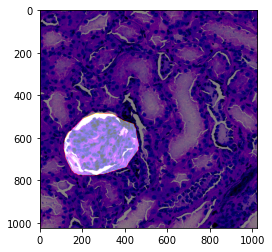

In [69]:
sample = ftu_dataset[3800]
show_kidney(**sample)

## Transformations

In [116]:
aug_train = Compose([Flip(p=0.5),
                     RandomRotate90(p=0.5),
                     Rotate(limit=180, p=0.5),
                     Normalize(max_pixel_value=255.0),
        ])

## check transforms are actually doing something

In [117]:
transformed_dataset = KidneyFTUsDataset(root_dir = DATA_PATH, 
                                        csv_file = 'names.csv', 
                                        mask_file = 'mask.h5',
                                        transform=aug_train
                                           )


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


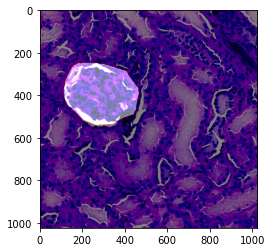

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


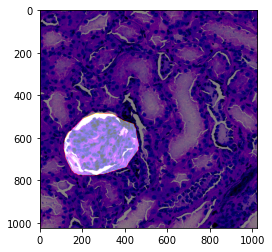

In [124]:
ind = 3800
show_kidney(**transformed_dataset[ind])
show_kidney(**ftu_dataset[ind])

In [125]:
dataloader = DataLoader(ftu_dataset, batch_size=4,
                        shuffle=True, num_workers=8)

0 torch.Size([4, 3, 1024, 1024]) torch.Size([4, 1, 1024, 1024])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1 torch.Size([4, 3, 1024, 1024]) torch.Size([4, 1, 1024, 1024])
2 torch.Size([4, 3, 1024, 1024]) torch.Size([4, 1, 1024, 1024])
3 torch.Size([4, 3, 1024, 1024]) torch.Size([4, 1, 1024, 1024])


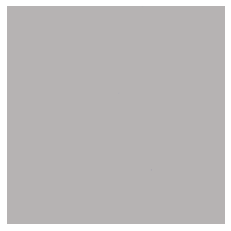

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


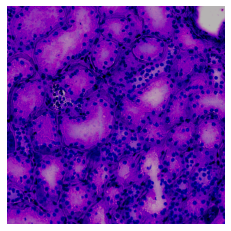

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


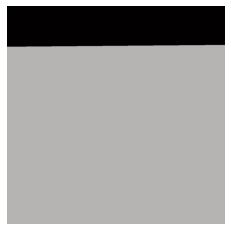

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


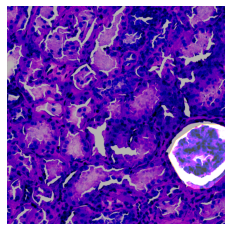

In [134]:
# Helper function to show a batch
def show_mask_batch(sample_batched):
    """Show image with masks for a batch of samples."""
    images_batch, masks_batch = \
            sample_batched['image'], sample_batched['mask']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    grid_border_size = 2

    grid = utils.make_grid(images_batch)
    
    grid1 = utils.make_grid(masks_batch)
    plt.imshow(grid1.numpy().T)

    plt.title('Batch from dataloader')

for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['mask'].size())

    # observe 4th batch and stop.
    if i_batch == 3:
        
        plt.figure()
        for i,im in enumerate(sample_batched['image']):
            plt.axis('off')
            plt.ioff()
            plt.imshow(im.permute(1,2,0))
            plt.imshow(sample_batched['mask'][i].numpy().transpose(1,2,0)[...,0],cmap = 'hot', alpha = 0.3)
            plt.show()
        break